In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

In [1]:
%config Completer.use_jedi = False

from qiskit import *
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import *

from helper.helper import *

import matplotlib.pyplot as plt
import numpy as np

In [2]:
qasm_backend = Aer.get_backend("qasm_simulator")

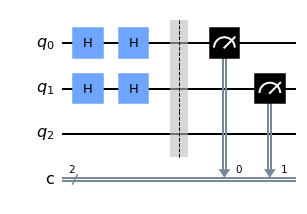

In [3]:
qc = QuantumCircuit(3, 2)

qc.h(range(2))

qc.h(range(2))

qc.barrier()
qc.measure(range(2), range(2))

qc.draw("mpl")

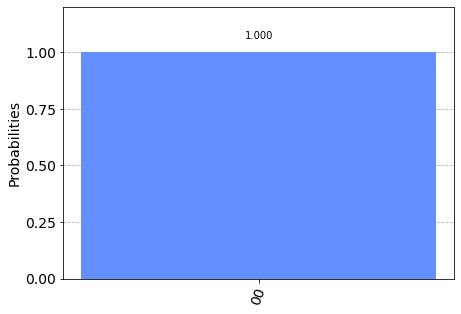

In [4]:
answer = run_for_result(qc)
plot_histogram(answer)

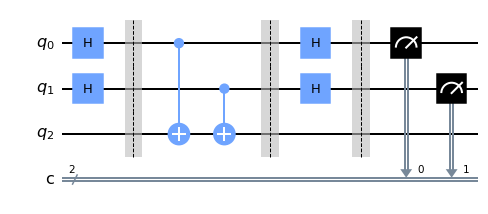

In [5]:
qc = QuantumCircuit(3, 2)

qc.h(range(2))
qc.barrier()

qc.cnot(0, 2)
qc.cnot(1, 2)

qc.barrier()
qc.h(range(2))


qc.barrier()
qc.measure(range(2), range(2))

qc.draw("mpl")

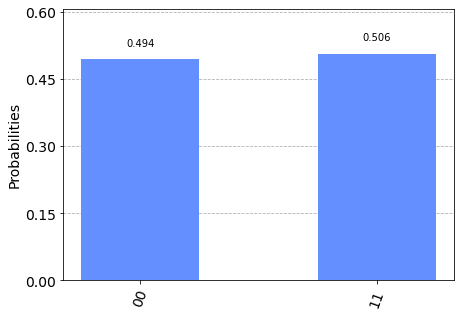

In [6]:
answer = run_for_result(qc)
plot_histogram(answer)

**Let's try to generate gates randomly**

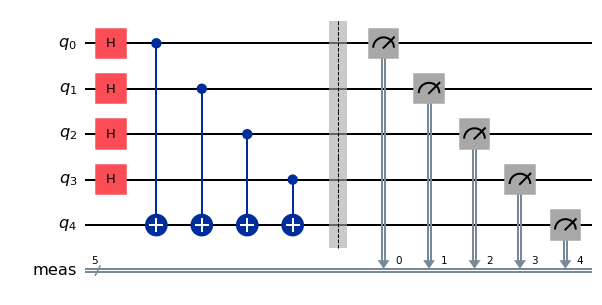

In [7]:
# Random number generator

n = 5

rnd_gen = QuantumCircuit(n)

rnd_gen.h(range(n - 1))

for i in range(n - 1):
    rnd_gen.cnot(i, n - 1)  # Because qubit starts from 0 and ends at 19. 
    
rnd_gen.measure_all()

rnd_gen.draw("mpl", style="iqx")

In [8]:
answer = run_for_result(rnd_gen)

In [9]:
random_numbers = [key for key in answer.keys()]
random_numbers

['00110',
 '11110',
 '10100',
 '01001',
 '01100',
 '00101',
 '11101',
 '10111',
 '00011',
 '00000',
 '01010',
 '01111',
 '11000',
 '10010',
 '11011',
 '10001']

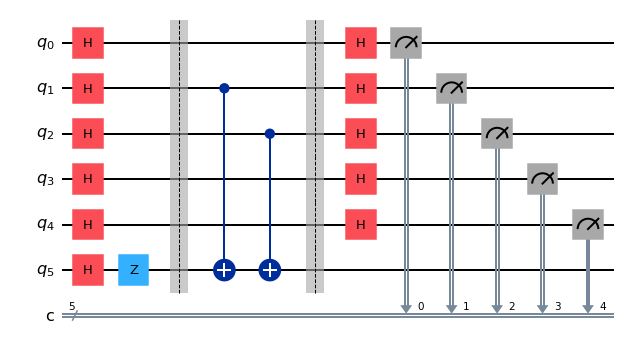

In [10]:
qc = QuantumCircuit(n + 1, n)

choice = np.random.randint(0, len(random_numbers))  # Choose a random number
choice = random_numbers[choice]  # Use the random number above to pick the location of str in our list of random numbers. 

# Put auxillary in state |->
qc.h(n)
qc.z(n)

# Main circuit (non auxillary)

qc.h(range(n))
qc.barrier()

for q in range(n):
    if choice[q] == "1":
        qc.cnot(q, n)


qc.barrier()
qc.h(range(n))

qc.measure(range(n), range(n))

qc.draw("mpl", style="iqx")

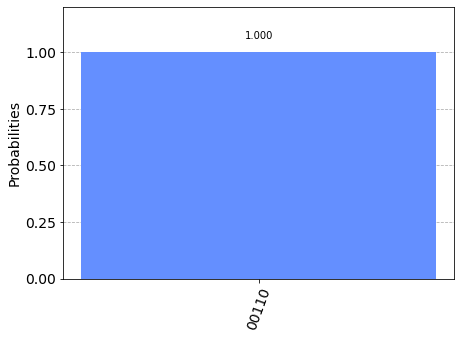

In [11]:
answer = run_for_result(qc)
plot_histogram(answer)

In [12]:
print(choice[::-1])

00110


We get the same value as in our "choice". Note that to visualize constructive and destructive interference in quantum computing, it's very easy. Whenever we have a constructive interference at one place, we have destructive interference at other place. For a perfect quantum computer like above it's difficult to show the "destructive" effect at other place, but if we have a noise model, we could show that there is only one place where the probabilities are extremely high and other places where probabilities are low. Let's show that. 

In [13]:
from qiskit.providers.aer import AerSimulator

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeParis

In [14]:
device_backend = FakeParis()

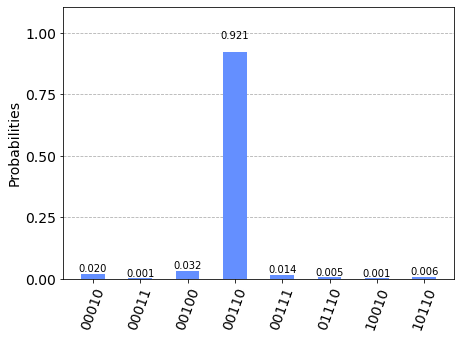

In [15]:
# We are only using the noise in FakeParis() model. 
noisy_backend = AerSimulator.from_backend(device_backend)

answer = run_for_result(qc, backend=noisy_backend)
plot_histogram(answer)

### What if we have interference? That is, what if we have some extra CNOT gates that comes from nowhere? Let's try to build that. 

Note we will not change `choice` here to retain and compare the difference with above. 

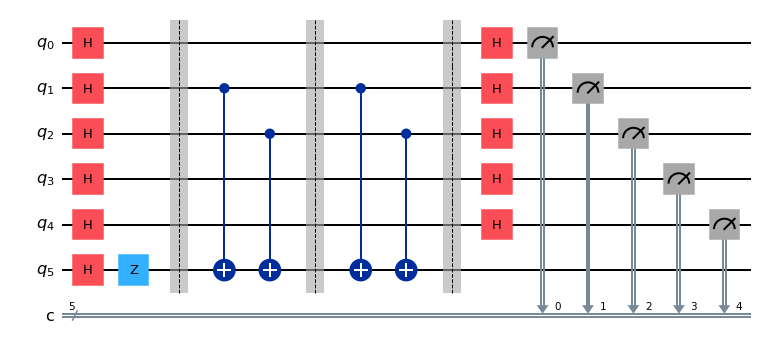

In [16]:
qc = QuantumCircuit(n + 1, n)


# Put auxillary in state |->
qc.h(n)
qc.z(n)

# Main circuit (non auxillary)

qc.h(range(n))
qc.barrier()

for q in range(n):
    if choice[q] == "1":
        qc.cnot(q, n)

# ============================
# Extra noise added here
qc.barrier()
for q in range(n):
    if choice[q] == "1":
        qc.cnot(q, n)

# ============================

qc.barrier()
qc.h(range(n))

qc.measure(range(n), range(n))

qc.draw("mpl", style="iqx")

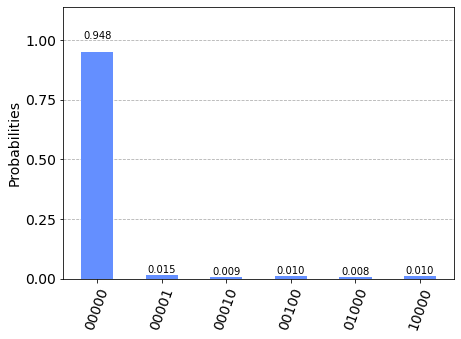

In [17]:
answer = run_for_result(qc, noisy_backend)
plot_histogram(answer)

With the same circuit repeated we see that the CNOT get interferes the result via global phase change and the result now interferes destructively at `00011` and instead constructively interfere at `00000`.

Up till now we have tried putting the "target" of a CNOT gate at the ancilla qubit, but what if we have CNOT gates target that is not part of the ancilla? Let's try doing that. 

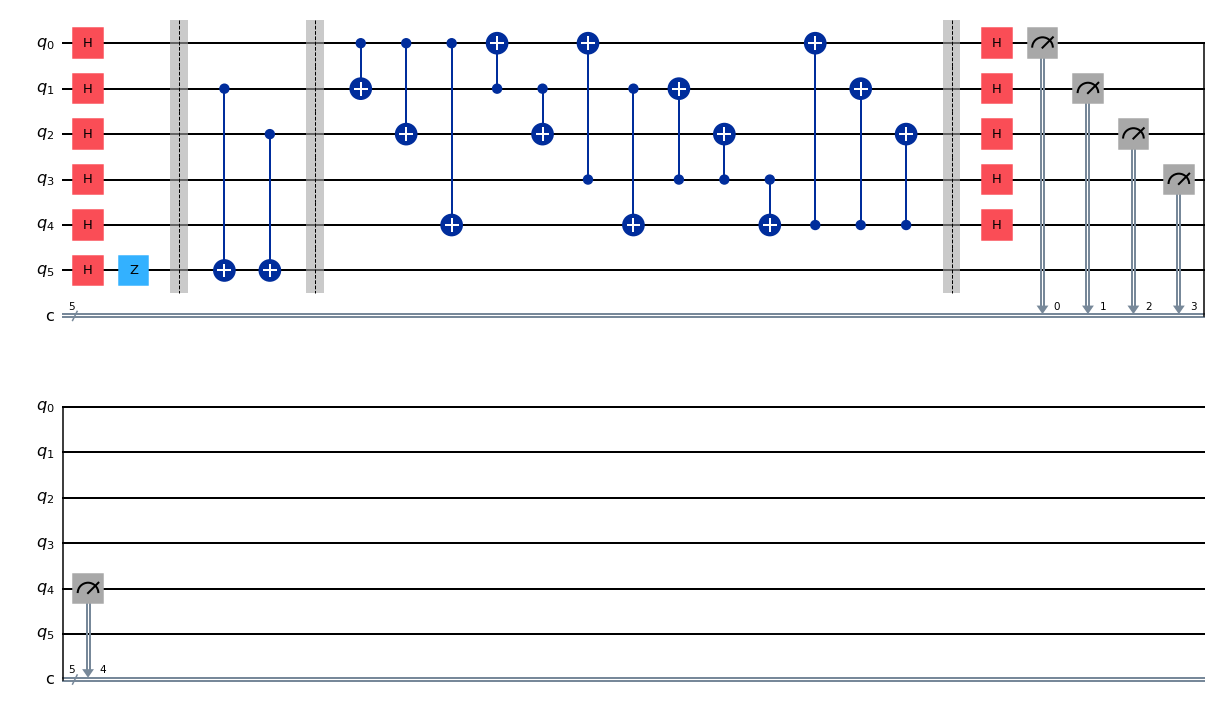

In [18]:
control_choice = np.random.randint(0, len(random_numbers))
control_choice = random_numbers[control_choice] 

target_choice = np.random.randint(0, len(random_numbers))
target_choice = random_numbers[target_choice]

qc = QuantumCircuit(n + 1, n)


# Put auxillary in state |->
qc.h(n)
qc.z(n)

# Main circuit (non auxillary)

qc.h(range(n))
qc.barrier()

for q in range(n):
    if choice[q] == "1":
        qc.cnot(q, n)

# ============================
# Extra noise added here
qc.barrier()

for q in range(n):  # stubborn method of programming. 
    if control_choice[q] == "1":
        
        for r in range(n):
            if target_choice[r] == "1" and q != r:
                    qc.cnot(q, r)

# ============================

qc.barrier()
qc.h(range(n))

qc.measure(range(n), range(n))

qc.draw("mpl", style="iqx")

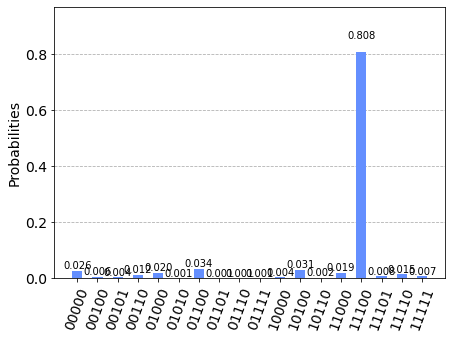

In [19]:
answer = run_for_result(qc, backend=noisy_backend)
plot_histogram(answer)

Okay either the constructive interference is to some other number of do not change, so this is not very stable. Let's try something else. Let's try to add Rotation phase gates randomly. We would see these phase gates as "disturbance" just like water waves being disturbed. 

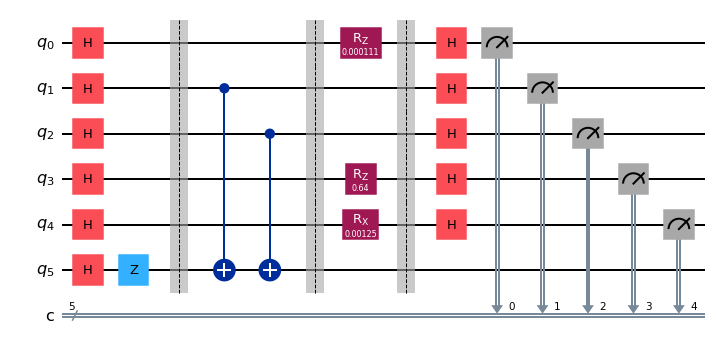

In [20]:
# Choose which qubits to implement the rotation phase gate to. 
implement_choice = np.random.randint(0, len(random_numbers))
implement_choice = random_numbers[implement_choice]

# Choose what type of gate to implement: 
# 0 = Rx, 1 = Ry, 2 = Rz; 
gate_random = random_number_generator(3)

# What is the phase? 
# We will retrieve a phase for each gate so to make it random. 
phase_random = random_number_generator(9)

qc = QuantumCircuit(n + 1, n)


# Put auxillary in state |->
qc.h(n)
qc.z(n)

# Main circuit (non auxillary)

qc.h(range(n))
qc.barrier()

for q in range(n):
    if choice[q] == "1":
        qc.cnot(q, n)

# ============================
# Extra noise added here
qc.barrier()

gate_number = 0

for q in range(n):
    if choice[q] == "0":  # We can choose "1" as well I just want to be random and choose "0". 
        
        # Phase: (ignore how it is chosen because that's just to make it random)
        theta = np.pi * int(phase_random[gate_number * 2], 2) / int(phase_random[gate_number * 2 + 1])
        
        # Choose which gate: Convert from binary to decimal: 
        if int(gate_random[gate_number], 2) == 0:
            qc.rx(theta, q)
        elif int(gate_random[gate_number], 2) == 1:
            qc.ry(theta, q)
        else: 
            qc.rz(theta, q)
            
        gate_number += 1
        

# ============================

qc.barrier()
qc.h(range(n))

qc.measure(range(n), range(n))

qc.draw("mpl", style="iqx")

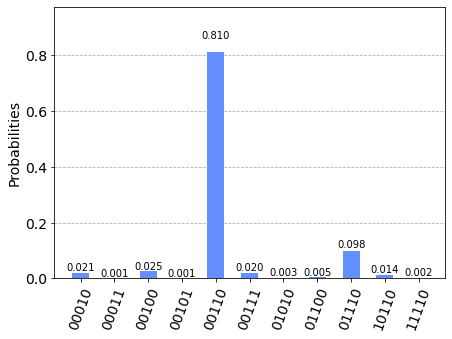

In [21]:
answer = run_for_result(qc, backend=noisy_backend)
plot_histogram(answer)

Ok now we see that except for the main, we actually have another constructive interference (albeit much more less than the main constructive wave). This is interesting. Let's see it with a perfect simulator to get a grasp of it if you don't believe. 

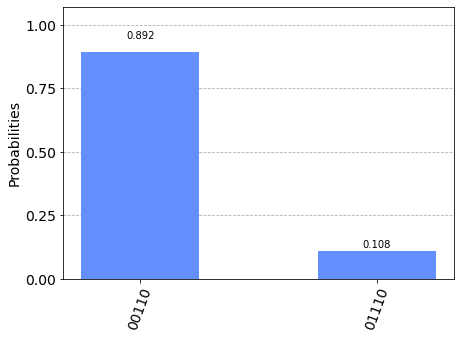

In [22]:
answer = run_for_result(qc)
plot_histogram(answer)

This means now we have 2 constructive wave and others are destructive at other regions not shown above.

**Let me remind you again that constructive and destructive are relative. Where we have one place of constructive which catches our attention, the other places which we consider as "background" are places of destructive interference.**

Related to the Quantum Key Distribution (QKD) virus file, I am thinking that whether these "virus" (or "noise", if that's in your preference) could make alterations in such a way that a string of bits being transmitted, when changed phase in the middle, are converted into a string of virus. All in all virus are just made of bits too, nothing different, so in the future perhaps there's some way that bad guy tries to inject virus without measurement necessary, who knows? 